<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [62]:
import pandas as pd
import urllib.parse
import urllib.request
import xml.etree.ElementTree as ET
import io
from bs4 import BeautifulSoup
import time
import sys
import multiprocessing as mp
import numpy as np

In [ ]:
def scrape_all_info2(idlist):
    fieldlist = ['language', 'itemnumber', 'itemname', 'price', 'productsize', 'isdiscontinued', 'islimited',
                 'am', 'ambonusmiles', 'amexpiration', 'kosher', 
                 'lto', 'ltoexpiration', 'ltoregularprice', 'ltosavings', 
                 'releasedate', 'upcnumber', 'sccnumber', 'vao', 'vaodescription', 'vaoexpiration', 
                 'vqa', 'productquantity', 'producer', 'producingsubregion', 'producingregion', 'producingcountry', 
                 'alcoholpercentage', 'sugarcontent', 'tastingnotes', 'pairings', 
                 'itemdescription', 'liquortype', 'categoryname', 'stocktype', 'subcategoryname',
                 'sellingpackage', 'sweetnessdescriptor', 'winestyle', 'winevarietal', 
                 'stylebody', 'stylebody_fr', 'styleflavour', 'styleflavour_fr']

    productinfo = pd.DataFrame(columns=fieldlist)
    
    #timer/counter
    start_time = int(time.time())
    count = 0
    total = len(idlist)
    
    pool = mp.Pool(mp.cpu_count())
    for id in idlist:
        pool.apply_async(parse_item_xml, args=(str(id),fieldlist), callback =collect_result)
        #print(id)
        # Pull xml from lcbo api
        #xmltest = pullXML(str(id))
        # Extract dict of values
        #newitem = parse_item_xml(xmltest, fieldlist)

        # Add to our dataframe
        #productinfo = productinfo.append(newitem,ignore_index=True)
    pool.close()
    pool.join()
    #print(results)
    return results
        #counter/timer
        #end_time = int(time.time())
        #min_spent = round(((end_time-start_time)/60),2)
        #remaining_time = round((min_spent/max(count,1))*max((total-count),1),2)

        #count_str = 'extracted ' + str(count) + '/' + str(total) + \
        #        ' products in total ' + str(min_spent) + ' minutes' + \
        #        ' estimated time remaining is ' + str(remaining_time) + ' minutes'
        #if count % 100 == 0:
        #    sys.stdout.write("\r{}".format(count_str))
        #count += 1
        
        # sleep so we don't get blacklisted
        #time.sleep(0.5)
        
    #save to parquet, also return the pandas dataframe
    #productinfo.to_parquet("productinfo2.parquet")
    #return productinfo

In [ ]:
def collect_result(result):
    #print('hi')
    global results
    #print('------')
    #print(result)
    results = results.append(result,ignore_index = True)
    #print(results)

In [ ]:
def parse_item_xml(id, fieldlist):
    #print(id)
    #print(fieldlist)
    xmlstring = pullXML(id)
    #print(xmlstring)
    soup = BeautifulSoup(xmlstring)
    product = soup.find('products')
    
    newitem = {}
    #print(fieldlist)
    for field in fieldlist:
        value = product.find(field)
        if value is not None:
            newitem[field] = value.text
    #print(newitem)
    return newitem

In [ ]:
def pullXML(ProductID):
    url = 'http://www.foodanddrink.ca/lcbo-webapp/productdetail.do?itemNumber=' + ProductID
    #print(url)
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    values = {'language' : 'en' }
    headers = { 'User-Agent' : user_agent }
    data = urllib.parse.urlencode(values)
    data = data.encode('ascii')
    req = urllib.request.Request(url, data, headers)
    #print('hi')
    try:
        with urllib.request.urlopen(req) as response:
           content = response.read()
        #print(content)
        return content
        #return BeautifulSoup(content, 'xml')
    except :
        #print(response)
        raise response
        

The cell below will pull for all item ranges, using a multiprocess in order to execute faster.

This will take quite a while. It took about 3 days for me.

In [15]:
fieldlist = ['language', 'itemnumber', 'itemname', 'price', 'productsize', 'isdiscontinued', 'islimited',
                 'am', 'ambonusmiles', 'amexpiration', 'kosher', 
                 'lto', 'ltoexpiration', 'ltoregularprice', 'ltosavings', 
                 'releasedate', 'upcnumber', 'sccnumber', 'vao', 'vaodescription', 'vaoexpiration', 
                 'vqa', 'productquantity', 'producer', 'producingsubregion', 'producingregion', 'producingcountry', 
                 'alcoholpercentage', 'sugarcontent', 'tastingnotes', 'pairings', 
                 'itemdescription', 'liquortype', 'categoryname', 'stocktype', 'subcategoryname',
                 'sellingpackage', 'sweetnessdescriptor', 'winestyle', 'winevarietal', 
                 'stylebody', 'stylebody_fr', 'styleflavour', 'styleflavour_fr']

results = pd.DataFrame(columns=fieldlist)

for i in range(1,111):
    maxrange = i * 10000
    minrange = (i-1) * 10000 + 1
    print('--')
    print(str(minrange) + ' to ' + str(maxrange))
    product_info_current = scrape_all_info2(range(minrange,maxrange)).dropna()
    product_info_current.to_parquet('data/product_info'+str(maxrange)+'.parquet')
    

--
1090001 to 1100000


Now let's consolidate all the files we've scraped:

In [99]:
from pathlib import Path
import pandas as pd

data_dir = Path('data/')
full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('product_info*.parquet')
)

In [100]:
full_df = full_df.dropna()

Fix datatypes:

In [101]:
full_df.dtypes

language               object
itemnumber             object
itemname               object
price                  object
productsize            object
isdiscontinued         object
islimited              object
am                     object
ambonusmiles           object
amexpiration           object
kosher                 object
lto                    object
ltoexpiration          object
ltoregularprice        object
ltosavings             object
releasedate            object
upcnumber              object
sccnumber              object
vao                    object
vaodescription         object
vaoexpiration          object
vqa                    object
productquantity        object
producer               object
producingsubregion     object
producingregion        object
producingcountry       object
alcoholpercentage      object
sugarcontent           object
tastingnotes           object
pairings               object
itemdescription        object
liquortype             object
categoryna

In [182]:
full_df=pd.read_parquet('data/productinfo_combined.parquet')

# TODO: a lot of these are just patterns that repeat so could be made into functions, 
#or ideally loop through all columns in one go.
pd.options.mode.chained_assignment = None
full_df['language']            = full_df['language'].astype('str')
full_df['itemnumber']          = full_df['itemnumber'].astype(int)
full_df['itemname']            = full_df['itemname'].astype('str')

# Strip the $ From price
full_df['price']               = full_df['price'].str.replace('$', '', case=False, regex=False).astype(float)
                                                    
# Strip productsize into quantity, volume and remove ml
full_df['quantity']            = (full_df['productsize'].replace('N/A', None)
                                                        .str.extract('(^.*)(?=x)')
                                                        .replace(np.nan,'1')
                                                        .astype(int)
                                 )

full_df['productsize']          = (full_df['productsize'].replace('(^.*x)','',regex=True)
                                                          .str.extract('(\d*)')
                                                          .replace('',None,regex=False)
                                                          .astype(int)
                                  )

full_df['isdiscontinued']      = full_df['isdiscontinued'].astype(bool)
full_df['islimited']           = full_df['islimited'].astype(bool)

# Convert N to False and Y to True
full_df['am']                  = full_df['am'] == 'Y'

full_df['ambonusmiles']        = full_df['ambonusmiles'].replace('','0',regex=False).astype(int)
full_df['amexpiration']        = pd.to_datetime(full_df.amexpiration.replace("N/A",'',regex=False))

full_df['kosher']              = full_df['kosher'] == 'Y'
full_df['lto']                 = full_df['lto'] == 'Y'

full_df['ltoexpiration']       = pd.to_datetime(full_df.ltoexpiration.replace("N/A",'',regex=False))
full_df['ltoregularprice']     = full_df['ltoregularprice'].str.replace('$', '', case=False, regex=False).astype(float)
full_df['ltosavings']          = full_df['ltosavings'].str.replace('$', '', case=False, regex=False).astype(float)

full_df['releasedate']         = pd.to_datetime(full_df.releasedate.replace("N/A",'',regex=False))

full_df['upcnumber']           = full_df['upcnumber'].astype(int)
full_df['sccnumber']           = full_df['sccnumber'].astype(int)

full_df['vao']                 = full_df['vao'] == 'Y'
full_df['vaodescription']      = full_df['vaodescription'].astype('str')
full_df['vaoexpiration']       = pd.to_datetime(full_df.vaoexpiration.replace("N/A",'',regex=False))

full_df['vqa']                 = full_df['vqa'] == 'Y'
full_df['productquantity']     = full_df['productquantity'].astype(int)

full_df['producer']            = full_df['producer'].astype(str)
full_df['producingsubregion']  = full_df['producingsubregion'].astype(str)
full_df['producingregion']     = full_df['producingregion'].astype(str)
full_df['producingcountry']    = full_df['producingcountry'].astype(str)

full_df['alcoholpercentage']   = (full_df['alcoholpercentage'].replace('\%', '', regex=True)
                                                              .replace("N/A",'',regex=False)
                                                              .replace('','0', regex=False)
                                                              .astype(float)
                                 )

full_df['sugarcontent']        = full_df['sugarcontent'].str.extract('(\d*)')
full_df['tastingnotes']        = full_df['tastingnotes'].astype(str)
full_df['pairings']            = full_df['pairings'].astype(str)
full_df['itemdescription']     = full_df['itemdescription'].astype(str)
full_df['liquortype']          = full_df['liquortype'].astype(str)
full_df['categoryname']        = full_df['categoryname'].astype(str)
full_df['stocktype']           = full_df['stocktype'].astype(str)
full_df['subcategoryname']     = full_df['subcategoryname'].astype(str)
full_df['sellingpackage']      = full_df['sellingpackage'].astype(str)
full_df['sweetnessdescriptor'] = full_df['sweetnessdescriptor'].astype(str)
full_df['winestyle']           = full_df['winestyle'].astype(str)
full_df['winevarietal']        = full_df['winevarietal'].astype(str)
full_df['stylebody']           = full_df['stylebody'].astype(str)
full_df['stylebody_fr']        = full_df['stylebody_fr'].astype(str)
full_df['styleflavour']        = full_df['styleflavour'].astype(str)
full_df['styleflavour_fr']     = full_df['styleflavour_fr'].astype(str)

In [183]:
full_df.to_parquet('data/lcbo_productinfo.parquet')

And let's take a look at the distribution of product codes:

In [172]:
full_df.dtypes

language                       object
itemnumber                      int64
itemname                       object
price                         float64
productsize                     int64
isdiscontinued                   bool
islimited                        bool
am                               bool
ambonusmiles                    int64
amexpiration           datetime64[ns]
kosher                           bool
lto                              bool
ltoexpiration          datetime64[ns]
ltoregularprice               float64
ltosavings                    float64
releasedate            datetime64[ns]
upcnumber                       int64
sccnumber                       int64
vao                              bool
vaodescription                 object
vaoexpiration          datetime64[ns]
vqa                              bool
productquantity                 int64
producer                       object
producingsubregion             object
producingregion                object
producingcou

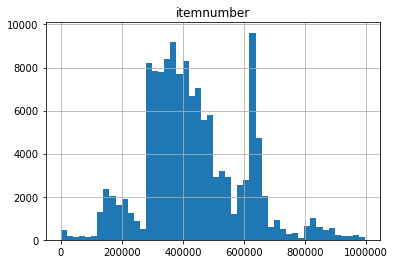

In [179]:
hist = full_df.hist(column = 'itemnumber', bins = 50)

In [175]:
full_df.itemnumber.max()

997353